# Imaginative Networks: Untimely Reference and Political Crisis in Early Modern Book Dedications

This notebook includes code for the tables and visualizations used in the article. It uses the output of `src/epnetwork.py`, which itself is based on hand-curated data from `src/epnames.py`.

In [1]:
# Begin by importing necessary libraries
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import bipartite, community
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pyvis.network import Network
from random import sample

plt.style.use('ggplot') # Automatically give all charts nice styling

# Two custom functions for splitting the network by time

def filter_by_year(year, B):
    """
    A function for creating subgraphs for each year
    """
    nodes = []
    for n in B.nodes(data=True):
        if n[1]['bipartite'] != 'person' and n[1]['date'] != 'No date listed':
            if int(n[1]['date']) == year:
                nodes.append(n[0])
                nodes.extend(B.neighbors(n[0]))
    SB = B.subgraph(nodes)
    return SB

def filter_by_range(start_year,end_year, B):
    """
    Similar to the year filter (above), filter the
    full graph by a range of years and create a subgraph.
    """
    nodes = []
    for n in B.nodes(data=True):
        if n[1]['bipartite'] != 'person' and n[1]['date'] != 'No date listed':
            if int(n[1]['date']) in range(start_year, end_year):
                nodes.append(n[0])
                nodes.extend(B.neighbors(n[0]))
    SB = B.subgraph(nodes)
    return SB

In [2]:
B = nx.read_gpickle('../data/test_joined0826.pkl')
print(nx.info(B))
for n,d in B.nodes(data=True):
    try:
        if d['date'] == None:
            B.nodes[n]['date'] = 'No date listed'
    except KeyError:
        pass
    if d['bipartite'] == 'person':
        B.nodes[n]['displayname'] = B.nodes[n]['display_name']
        del B.nodes[n]['display_name']

names = {n for n,d in B.nodes(data=True) if d['bipartite'] == 'person'}
print("Names:", len(names))

print("Texts:", len({n for n,d in B.nodes(data=True) if d['bipartite'] == 'text'}))

print("Density:", bipartite.density(B, names))

Name: 
Type: Graph
Number of nodes: 54679
Number of edges: 113862
Average degree:   4.1647
Names: 42687
Texts: 11992
Density: 0.0002224290741113468


In [3]:
# Basic Data on Network

def get_data(B):
    texts = len({n for n,d in B.nodes(data=True) if d['bipartite'] == 'text'})
    dedicators = []
    dedicatees = []
    others = []
    for s,t,d in B.edges(data=True):
        if type(t) == str:
            p = s
        else:
            p = t
        if d['isauthor'] == 'true':
            dedicators.append(p)
        elif 'head' in d['container']:
            dedicatees.append(p)
        else:
            others.append(p)
    return {'# texts': texts, '# dedicators': len(set(dedicators)), '# dedicatees': len(set(dedicatees)), '# others': len(set(others))}

decade_data = {}
for x in range(1470,1710,10):
    SB = filter_by_range(x, x+10, B)
    decade_data[f"{x}-{x+9}"] = get_data(SB)



no_date_nodes = []
for n in B.nodes(data=True):
    try:
        if n[1]['date'] == "No date listed":
            no_date_nodes.append(n[0])
            no_date_nodes.extend(B.neighbors(n[0]))
    except (KeyError, ValueError, TypeError) as e:
        pass
no_date_graph = B.subgraph(no_date_nodes)
decade_data["No date listed"] = get_data(no_date_graph)

df = pd.DataFrame(decade_data)
df = df.T

all_texts = pd.read_csv("../data/ep_counts_decade.csv", header=None)
all_texts = all_texts.drop([24,25,26,27])
all_texts.index=df.index
df.insert(0, 'total texts', all_texts[1])

total = df.sum()
total.name = 'Total'
df = df.append(total)

df
# df.to_csv("../data/data_summary.csv", sep='|')

total texts  # texts  # dedicators  # dedicatees  # others
1470-1479                17        1             0             0         6
1480-1489                37        1             0             3        12
1490-1499                48        1             0             0        14
1500-1509                66        0             0             0         0
1510-1519                64        0             0             0         0
1520-1529                84        7             2            12        35
1530-1539               240       22             3            32       202
1540-1549               387       80            17           139       487
1550-1559               371       90            28           161       525
1560-1569               451      140            29           250      1366
1570-1579               609      298            80           472      2009
1580-1589               855      462           139           662      2519
1590-1599              1046      539           157           755      2591
1600-1609              1518      763           221          1014      3530
1610-1619              1639      910           273          1271      3405
1620-1629              1998      843           236          1314      3332
1630-1639              1773      769           204          1221      3099
1640-1649              9355     1204           303          1180      3374
1650-1659              5909     1444           377          1717      5019
1660-1669              4980      960           294          1069      3922
1670-1679              4674      894           262          1133      3124
1680-1689              8168     1195           365          1538      4510
1690-1699              6797     1214           309          1520      4331
1700-1709               936      149            48           218       522
No date listed           55        5             1             8       165
Total                 52077    11991          3348         15689     48099

## Subgraph for 1660

In [22]:
# Create a subgraph for 1660
SB = filter_by_year(1660, B)
print("Full Network for 1660")

names = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}

degree_texts, degree_names = bipartite.degrees(SB, names)
degree_names_sorted = sorted(degree_names, key=lambda n:n[1], reverse=True)
degree_texts_sorted = sorted(degree_texts, key=lambda n:n[1], reverse=True)
strength_texts, strength_names = bipartite.degrees(SB, names, weight='weight')
# print(strength)
degree_centrality = bipartite.degree_centrality(SB, names)
print("\nTop Twenty People by Degree:\n")
for n,degree in degree_names_sorted[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")
    
# nx.write_gml(SB, "../data/test_1660.gml")
subnodes = [p[0] for p in degree_names_sorted[:25]]
neighbors = list(set(list(sum([list(SB.neighbors(s)) for s in subnodes], []))))
subnodes.extend(neighbors)
# print(subnodes)
# SB = SB.subgraph(subnodes)
print(nx.info(SB))
# names = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
texts = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'text'}
print("Names:", len(names))

print("Texts:", len(texts))
          
print("Density:", bipartite.density(SB, names))

Full Network for 1660

Top Twenty People by Degree:

126033|God|144|712|0.64
104495|Jesus Christ|65|225|0.289
111734|David|26|57|0.116
101427|Charles Ii|20|21|0.089
108610|St Paul|19|22|0.084
133188|Moses|18|27|0.08
110832|St John|16|17|0.071
105361|King James|15|19|0.067
140498|King Charles|14|15|0.062
141874|Solomon|14|23|0.062
106647|Satan|13|16|0.058
115297|King Henry|12|13|0.053
112509|St Thomas|8|8|0.036
135589|Caesar|7|12|0.031
125390|Job|7|10|0.031
126796|Queen Elizabeth|7|7|0.031
106425|General Monck|7|7|0.031
110709|Abraham|6|8|0.027
135309|William Prynne|6|7|0.027
111645|St Peter|6|6|0.027
Name: 
Type: Graph
Number of nodes: 1496
Number of edges: 1972
Average degree:   2.6364
Names: 1271
Texts: 225
Density: 0.006895707666754087


In [21]:
# Create node data for categorizing people
data = []
index = []
for n,d in SB.nodes(data=True):
    if d['bipartite'] == 'person':
        index.append(n)
        data.append(d)
    
all_people = pd.DataFrame(data, index=index)
all_people
# all_people.to_csv('../data/person_category_1660.csv')

In [23]:
index_1660 = []
data_1660 = []
for n,degree in degree_names:
    index_1660.append(n)
    data_1660.append({'name':SB.nodes[n]['displayname'], 'degree_all':degree, 'strength_all': strength_names[n], 'degree_centrality_all': round(degree_centrality[n],3)})
#     print(f"{n}|{SB.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")

df_1660 = pd.DataFrame(data_1660, index=index_1660)
df_1660#.sort_values(by='degree_all', ascending=False)

name  degree_all  strength_all  \
114688              St Gregory           1             1   
102403         Richard Matthew           1             1   
131078                 Patient           1             1   
139272                  Gusman           1             1   
114700  Captain Gilbert Crouch           1             1   
...                        ...         ...           ...   
122847        Earl Of Canaruan           1             1   
102373        Prophet Jeremiah           1             1   
131045            James Boevey           1             1   
122871     William Lord Craven           1             1   
102399               Tertul He           1             1   

        degree_centrality_all  
114688                  0.004  
102403                  0.004  
131078                  0.004  
139272                  0.004  
114700                  0.004  
...                       ...  
122847                  0.004  
102373                  0.004  
131045                  0.004  
122871                  0.004  
102399                  0.004  

[1271 rows x 4 columns]

1496


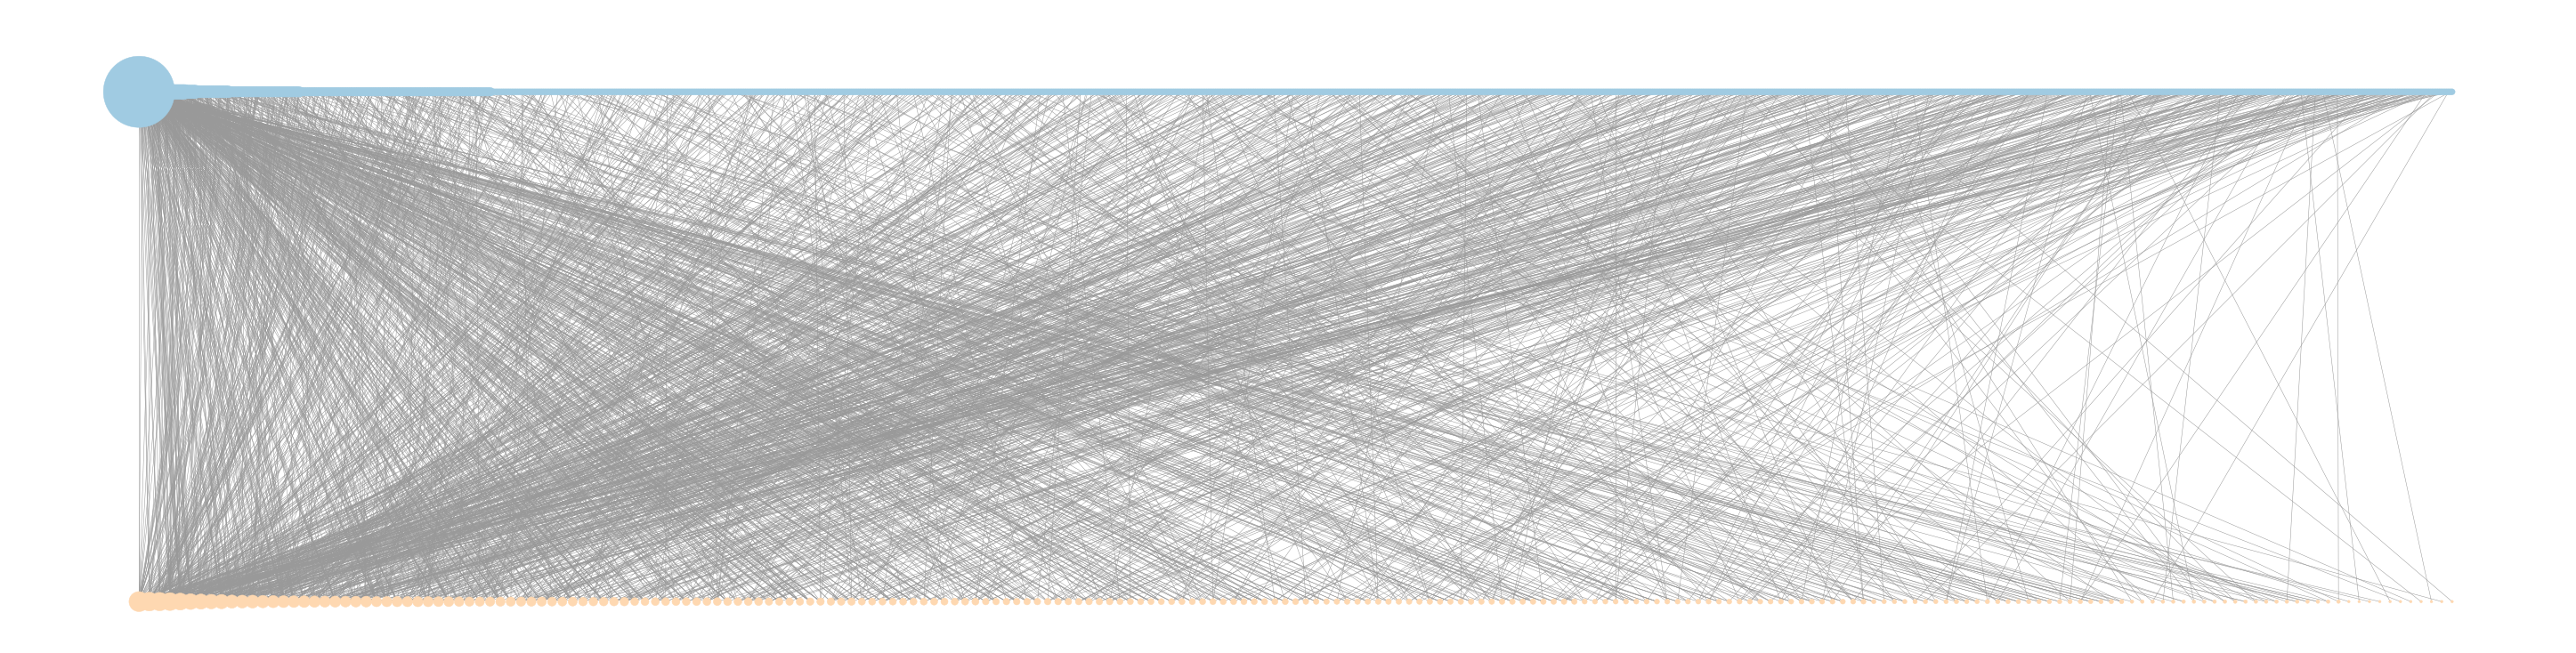

In [7]:
# Visualization of Full 1660 Graph

plt.figure(figsize=(40,10))
pos = nx.bipartite_layout(SB, names, aspect_ratio=4, align='horizontal')
print(len(list(pos.items())))
ordered_pos = {}
degree_names_sorted.reverse()
degree_texts_sorted.reverse()
# node_size = [d*300 for n,d in degree_names_sorted]
# node_size.extend([d for n,d in degree_texts_sorted])
# print(node_size)
node_size=[degree_centrality[n]*10000 for n in SB.nodes()]
node_color = ["#A0CBE2" if d['bipartite'] == 'person' else "#FED8B1" for n,d in SB.nodes(data=True)]
labels = {n:d['displayname'] if d['bipartite'] == 'person' else n for n,d in SB.nodes(data=True)}
for i,t in enumerate(pos.items()):
    if i < len(degree_names_sorted):
#         print(people_by_degree[i])
        ordered_pos[degree_names_sorted[i][0]] = t[1]
#         node_size.append(degree_names_sorted[i][1]*300)
    else:
        ordered_pos[degree_texts_sorted[i-len(degree_names_sorted)][0]] = t[1]
#         node_size.append(degree_texts_sorted[i-len(degree_names_sorted)][1]*300)
nx.draw(SB, pos=ordered_pos, node_color=node_color, node_size=node_size, edge_color='#999999',width=.5, with_labels=False, labels=labels)#, horizontalalignment='left')
plt.show()

Name: 
Type: Graph
Number of nodes: 60
Number of edges: 146
Average degree:   4.8667
60
60


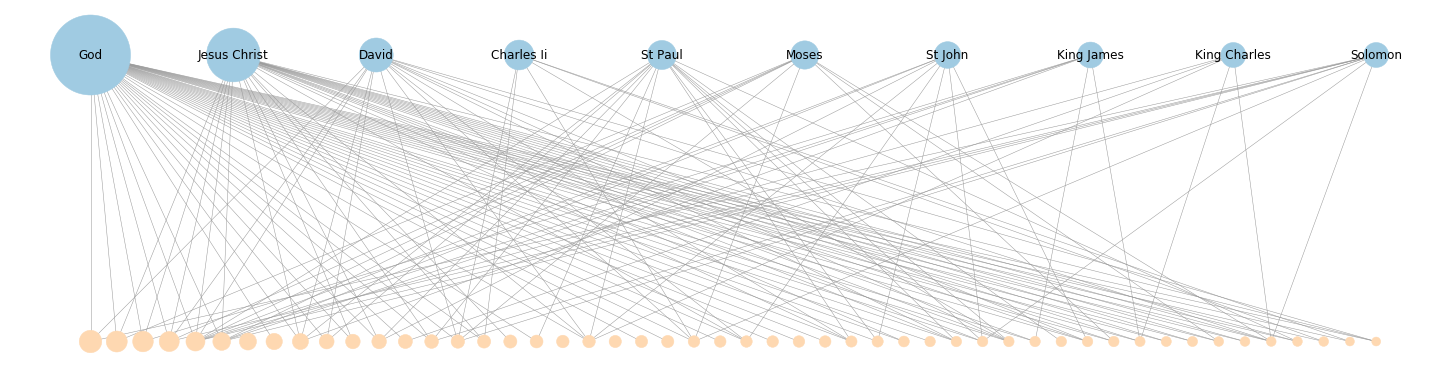

In [8]:
# Visualization of 1660 Graph, top ten names and top 50 texts only

top_ten_names = [n for n,d in degree_names_sorted[:10]]
top_ten_texts = [n for n,d in degree_texts_sorted[:50]]
top_ten_names.extend(top_ten_texts)

top_ten_subgraph = SB.subgraph(top_ten_names)
print(nx.info(top_ten_subgraph))
new_names = {n for n,d in top_ten_subgraph.nodes(data=True) if d['bipartite'] == 'person'}
plt.figure(figsize=(20,5))
pos_top_ten = nx.bipartite_layout(top_ten_subgraph, new_names, aspect_ratio=2, align='horizontal')
ordered_pos = {}
# node_size = [d*300 for n,d in degree_names_sorted]
# node_size.extend([d for n,d in degree_texts_sorted])
# print(node_size)
node_size=[degree_centrality[n]*10000 for n in top_ten_subgraph.nodes()]
node_color = ["#A0CBE2" if d['bipartite'] == 'person' else "#FED8B1" for n,d in top_ten_subgraph.nodes(data=True)]
labels = {n:d['displayname'] if d['bipartite'] == 'person' else '' for n,d in top_ten_subgraph.nodes(data=True)}
print(len(list(pos_top_ten.items())))
print(len(top_ten_names))
for i,t in enumerate(pos_top_ten.items()):
    ordered_pos[top_ten_names[i]] = t[1]
nx.draw(top_ten_subgraph, pos=ordered_pos, node_color=node_color, node_size=node_size, edge_color='#999999',width=.5, with_labels=True, labels=labels)#, horizontalalignment='left')
plt.show()

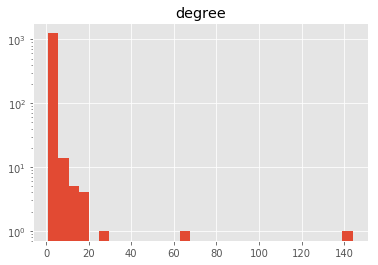

In [35]:
dc_names = {k:v for k,v in degree_centrality.items() if k in names}
degree_table = pd.DataFrame([dict(degree_names), dict(strength_names), dc_names], index=['degree','strength', 'degree centrality'])
degree_table.T.hist(column="degree", bins=30)
plt.yscale('log')
plt.show()

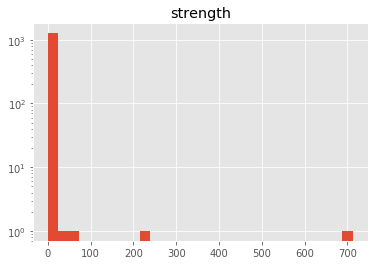

In [41]:
degree_table.T.hist(column="strength", bins=30)
plt.yscale('log')
plt.show()

In [50]:
# Density comparison
aseq = [d for n,d in degree_names]
x = 0
densities = []
while x < 10:
    R = bipartite.preferential_attachment_graph(aseq, len(texts)/len(names))
    top = {n for n,d in R.nodes(data=True) if d['bipartite'] == 0}
    print(nx.info(R))
    density = bipartite.density(R,top)
    print("Density", density)
    densities.append(density)
    x += 1
    
print("Average Density", sum(densities)/len(densities))

Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1599
Number of edges: 1972
Average degree:   2.4665
Density 0.004730287271401431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1631
Number of edges: 1972
Average degree:   2.4181
Density 0.004309817291721305
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1621
Number of edges: 1972
Average degree:   2.4331
Density 0.004432954928627627
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1627
Number of edges: 1972
Average degree:   2.4241
Density 0.004358242205111431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1599
Number of edges: 1972
Average degree:   2.4665
Density 0.004730287271401431
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 1604
Number of edges: 1972
Average degree:   2.4589
Density 0.004659261936996005
Name: bipartite_preferential_attac

In [67]:
# Strength/Degree comparison
print("Strength Over Degree")
strength_over_degree = {n:strength_names[n]/degree_names[n] for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
strength_over_degree = sorted(strength_over_degree.items(), key=lambda n:n[1], reverse=True)
for n, d in strength_over_degree[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{degree_names[n]}|{strength_names[n]}|{round(d,3)}")

Strength Over Degree
108936|Celsus|1|10|10.0
119927|Juvenal|1|6|6.0
113792|Jeroboam|3|18|6.0
107255|Jansenius|1|5|5.0
104296|Ephraim|1|5|5.0
128960|Therammenes|1|5|5.0
105583|Brounrig|1|5|5.0
126033|God|144|712|4.944
117031|Critias|1|4|4.0
109028|Ambrose|2|8|4.0
117768|Jehoshaphat|1|4|4.0
127113|John Heydon|1|4|4.0
119399|Eve|1|4|4.0
104495|Jesus Christ|65|225|3.462
123518|Thomas White|1|3|3.0
116693|Henry Jeanes|1|3|3.0
117265|Orbis|1|3|3.0
101079|Avicen|1|3|3.0
135617|Suarez|2|6|3.0
111052|Camerwell|1|3|3.0


In [70]:
# Betweenness/Degree Comparison
betweenness = bipartite.betweenness_centrality(SB, names)

betweenness_degree = {n:betweenness[n]/degree_centrality[n] for n,d in SB.nodes(data=True) if d['bipartite'] == 'person'}
betweenness_degree = sorted(betweenness_degree.items(), key=lambda n:n[1], reverse=True)
for n, d in betweenness_degree[:20]:
    print(f"{n}|{SB.nodes[n]['displayname']}|{round(betweenness[n],3)}|{round(degree_centrality[n],3)}|{round(d,3)}")

132630|Maecenas|0.018|0.013|1.366
104552|Vespasian|0.009|0.009|0.96
126033|God|0.553|0.64|0.864
137792|Thomas Bodley|0.006|0.009|0.687
113701|John Earnly|0.006|0.009|0.687
132460|Plato|0.008|0.013|0.622
133382|Hippocrates|0.008|0.013|0.616
134423|St James|0.01|0.018|0.578
112509|St Thomas|0.02|0.036|0.558
112708|Galen|0.005|0.009|0.547
136855|Mercury|0.007|0.013|0.52
139182|Plutarch|0.007|0.013|0.494
112174|Alexander|0.013|0.027|0.492
114830|John Calvin|0.004|0.009|0.428
137206|Nilus|0.004|0.009|0.413
137942|Urania|0.004|0.009|0.413
105886|Democracy|0.004|0.009|0.413
104495|Jesus Christ|0.115|0.289|0.398
134567|Phaeton|0.005|0.013|0.357
108864|Mars|0.004|0.013|0.329


## 1660 Subgraph -- node categories

In [5]:
categories = pd.read_csv('../data/person_category_1660.csv',index_col=0)
categories

bipartite             displayname category
114688    person              St Gregory        R
131078    person                 Patient        L
139272    person                  Gusman        L
114700    person  Captain Gilbert Crouch        L
131087    person                Burleigh        L
...          ...                     ...      ...
122820    person                Adonijah        R
122822    person      St Thomas Apostles        R
122847    person        Earl Of Canaruan        L
131045    person            James Boevey        L
122871    person     William Lord Craven        L

[1271 rows x 3 columns]

In [6]:
categories.groupby('category').count()
# categories.groupby('category').count().to_csv("../data/category_count.csv", sep='|')

bipartite  displayname
category                        
F                50           50
H               202          202
L               666          666
R               216          216
U               137          136

In [7]:
cat_dict = categories['category'].to_dict()
# print(cat_dict)
nx.set_node_attributes(SB, cat_dict, 'category')

In [8]:
d = pd.Series(dict(degree_names))
categories['degree'] = d
categories.groupby('category').mean('degree')

degree
category          
F         1.420000
H         1.514851
L         1.240240
R         2.898148
U         1.043796

In [18]:
container_dict = {}
for n,d in SB.nodes(data=True):
    if d['bipartite'] == 'person':
        container_list = list(sum([d['container'] for s,t,d in SB.edges(n, data=True)], []))
        container_list = set(container_list)
        if 'head' in container_list or 'signed' in container_list:
            container_dict[n] = 'header/signed'
        else:
            container_dict[n] = 'body'
            
nx.set_node_attributes(SB, container_dict, 'container')
c = pd.Series(container_dict)
categories['container'] = c
# categories
categories.groupby(['category', 'container']).count()#.to_csv('../data/category_container.csv', sep="|")

bipartite  displayname  degree
category container                                    
F        body                  49           49      49
         header/signed          1            1       1
H        body                 191          191     191
         header/signed         11           11      11
L        body                 259          259     259
         header/signed        407          407     407
R        body                 210          210     210
         header/signed          6            6       6
U        body                 118          117     118
         header/signed         19           19      19

In [12]:
categories.groupby(['category', 'container']).mean('degree')

degree
category container               
F        body            1.428571
         header/signed   1.000000
H        body            1.340314
         header/signed   4.545455
L        body            1.162162
         header/signed   1.289926
R        body            1.871429
         header/signed  38.833333
U        body            1.025424
         header/signed   1.157895

In [13]:
living_people = {n for n,d in SB.nodes(data=True) if d['bipartite'] == 'person' and d['category'] == 'L'}
living_edges = {(s,t) for s,t in SB.edges() if s in living_people or t in living_people}
LSB = SB.edge_subgraph(living_edges)
print(nx.info(LSB))

Name: 
Type: Graph
Number of nodes: 885
Number of edges: 826
Average degree:   1.8667


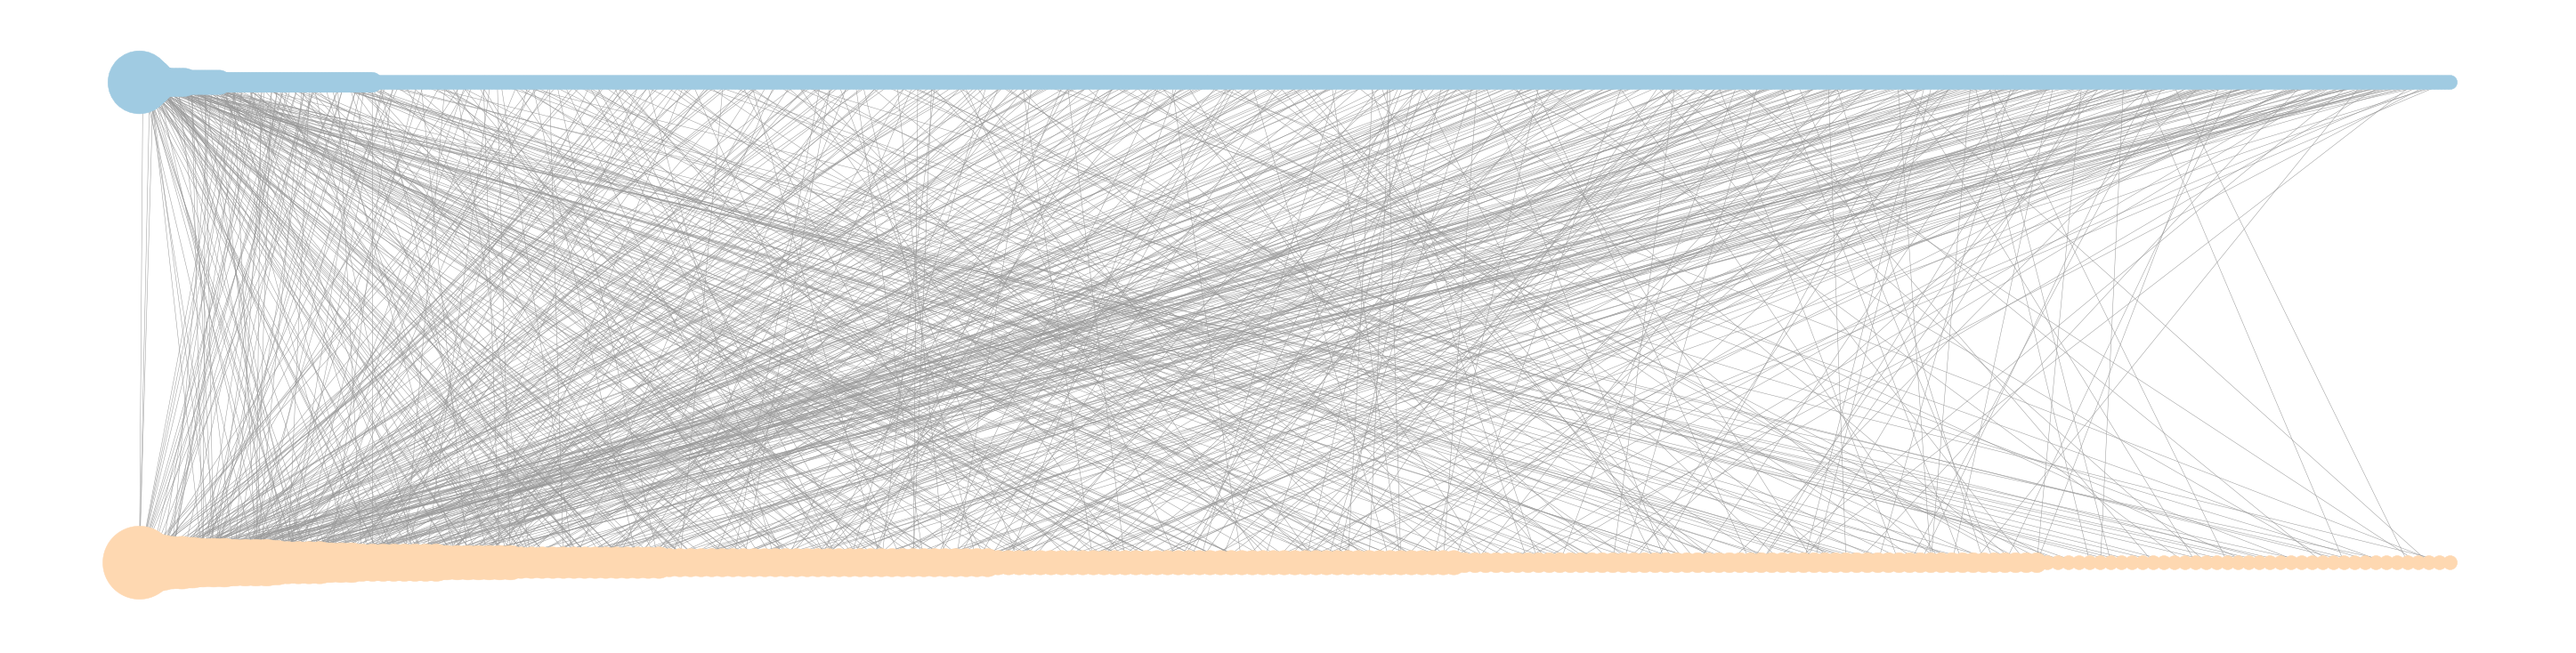

In [52]:
# Visualization of 1660 Graph, living category only

names = {n for n,d in LSB.nodes(data=True) if d['bipartite'] == 'person'}
degree_texts, degree_names = bipartite.degrees(LSB, names)
degree_names_sorted = sorted(degree_names, key=lambda n:n[1], reverse=True)
degree_texts_sorted = sorted(degree_texts, key=lambda n:n[1], reverse=True)

plt.figure(figsize=(40,10))
pos = nx.bipartite_layout(LSB, names, aspect_ratio=4, align='horizontal')
# print(len(list(pos.items())))
ordered_pos = {}
# degree_names_sorted.reverse()
# degree_texts_sorted.reverse()

# print(node_size)
node_size=[LSB.degree(n)*250 for n in LSB.nodes()]
node_color = ["#A0CBE2" if d['bipartite'] == 'person' else "#FED8B1" for n,d in LSB.nodes(data=True)]
labels = {n:d['displayname'] if d['bipartite'] == 'person' else n for n,d in LSB.nodes(data=True)}
for i,t in enumerate(pos.items()):
    if i < len(degree_names_sorted):
#         print(people_by_degree[i])
        ordered_pos[degree_names_sorted[i][0]] = t[1]
#         node_size.append(degree_names_sorted[i][1]*300)
    else:
        ordered_pos[degree_texts_sorted[i-len(degree_names_sorted)][0]] = t[1]
#         node_size.append(degree_texts_sorted[i-len(degree_names_sorted)][1]*300)
nx.draw(LSB, pos=ordered_pos, node_color=node_color, node_size=node_size, edge_color='#999999',width=.5, with_labels=False, labels=labels)#, horizontalalignment='left')
plt.show()

In [45]:
for n,d in degree_names_sorted[:20]:
    print(LSB.nodes[n]['displayname'], d)

Charles Ii 20
King James 15
King Charles 14
King Henry 12
Queen Elizabeth 7
General Monck 7
William Prynne 6
Lord Will 5
King Edward 4
Thomas Aleyn 4
Richard Baxter 4
Charles I 4
Edward Reynolds 4
Kings-Norton 4
Martin Luther 3
John Robinson 3
William Towers 3
J Gauden 3
Thomas Hall 3
Richard Brown 3


## 1660 Subgraph -- Header/Signed

In [24]:
# Create subgraph of 1660 graph with only names that appear in header or signature of dedication

edgeset = [(s,t) for s,t,d in SB.edges(data=True) if "head" in d['container'] or "signed" in d['container']]
SB_header_signed = SB.edge_subgraph(edgeset)
print(nx.info(SB_header_signed))

hs_names = {n for n,d in SB_header_signed.nodes(data=True) if d['bipartite'] == 'person'}
hs_texts = {n for n,d in SB_header_signed.nodes(data=True) if d['bipartite'] == 'text'}

print("Names:", len(hs_names))

print("Texts:", len(hs_texts))
          
print("Density:", bipartite.density(SB_header_signed, hs_names))

Name: 
Type: Graph
Number of nodes: 647
Number of edges: 553
Average degree:   1.7094
Names: 444
Texts: 203
Density: 0.006135445790618204


In [25]:
degree_texts, degree_names = bipartite.degrees(SB_header_signed, hs_names)
degree_names_sorted = sorted(degree_names, key=lambda n:n[1], reverse=True)
degree_texts_sorted = sorted(degree_texts, key=lambda n:n[1], reverse=True)
strength_texts, strength_names = bipartite.degrees(SB_header_signed, hs_names, weight='weight')
# print(strength)
degree_centrality = bipartite.degree_centrality(SB_header_signed, hs_names)
print("\nTop Ten People by Degree:\n")
for n,degree in degree_names_sorted[:20]:
    print(f"{n}|{SB_header_signed.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")


Top Ten People by Degree:

104495|Jesus Christ|19|107|0.094
101427|Charles Ii|17|18|0.084
126033|God|11|85|0.054
140498|King Charles|6|6|0.03
112509|St Thomas|6|6|0.03
135309|William Prynne|5|6|0.025
115297|King Henry|5|5|0.025
110832|St John|4|4|0.02
101782|Edward Reynolds|4|4|0.02
123321|Thomas Aleyn|4|4|0.02
118957|John Robinson|3|3|0.015
106863|William Towers|3|3|0.015
141705|J Gauden|3|3|0.015
135637|Thomas Hall|3|3|0.015
125505|Richard Baxter|3|3|0.015
135861|Richard Brown|3|3|0.015
105361|King James|3|3|0.015
106425|General Monck|3|3|0.015
113701|John Earnly|2|2|0.01
135252|William Paston|2|2|0.01


In [56]:
index_1660_header = []
data_1660_header = []
for n,degree in degree_names:
    index_1660_header.append(n)
    data_1660_header.append({'name':SB_header_signed.nodes[n]['displayname'], 'degree':degree, 'strength': strength_names[n], 'degree_centrality': round(degree_centrality[n],3)})
#     print(f"{n}|{SB.nodes[n]['displayname']}|{degree}|{strength_names[n]}|{round(degree_centrality[n],3)}")

df_1660_header = pd.DataFrame(data_1660_header, index=index_1660_header)
# df_1660_header
df_1660_header#.sort_values(by='degree_all', ascending=False)
df_1660['degree_header'] = df_1660_header['degree']
df_1660['strength_header'] = df_1660_header['strength']
df_1660['degree_centrality_header'] = df_1660_header['degree_centrality']
df_1660.sort_values(by='degree_all', ascending=False)

name  degree_all  strength_all  \
126033                          God         144           712   
104495                 Jesus Christ          65           225   
111734                        David          26            57   
101427                   Charles Ii          20            21   
108610                      St Paul          19            22   
...                             ...         ...           ...   
136686                  Lord Lumley           1             1   
136665                      Orpheus           1             1   
112089  Elizabeth Countess Of Clare           1             1   
107992                 Joseph Caryl           1             1   
102399                    Tertul He           1             1   

        degree_centrality_all  degree_header  strength_header  \
126033                  0.640           11.0             85.0   
104495                  0.289           19.0            107.0   
111734                  0.116            NaN              NaN   
101427                  0.089           17.0             18.0   
108610                  0.084            1.0              2.0   
...                       ...            ...              ...   
136686                  0.004            1.0              1.0   
136665                  0.004            NaN              NaN   
112089                  0.004            1.0              1.0   
107992                  0.004            1.0              1.0   
102399                  0.004            NaN              NaN   

        degree_centrality_header  
126033                     0.054  
104495                     0.094  
111734                       NaN  
101427                     0.084  
108610                     0.005  
...                          ...  
136686                     0.005  
136665                       NaN  
112089                     0.005  
107992                     0.005  
102399                       NaN  

[1271 rows x 7 columns]

In [57]:
df_1660.corr(method='pearson')

degree_all  strength_all  degree_centrality_all  \
degree_all                  1.000000      0.962710               0.999962   
strength_all                0.962710      1.000000               0.961642   
degree_centrality_all       0.999962      0.961642               1.000000   
degree_header               0.676312      0.541220               0.677697   
strength_header             0.875109      0.821441               0.875145   
degree_centrality_header    0.673724      0.538014               0.675124   

                          degree_header  strength_header  \
degree_all                     0.676312         0.875109   
strength_all                   0.541220         0.821441   
degree_centrality_all          0.677697         0.875145   
degree_header                  1.000000         0.799099   
strength_header                0.799099         1.000000   
degree_centrality_header       0.999983         0.797013   

                          degree_centrality_header  
degree_all                                0.673724  
strength_all                              0.538014  
degree_centrality_all                     0.675124  
degree_header                             0.999983  
strength_header                           0.797013  
degree_centrality_header                  1.000000

In [58]:
from scipy.stats import pearsonr
    
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

df_1660.corr(method=pearsonr_pval)

degree_all   strength_all  degree_centrality_all  \
degree_all                 1.000000e+00   0.000000e+00           0.000000e+00   
strength_all               0.000000e+00   1.000000e+00           0.000000e+00   
degree_centrality_all      0.000000e+00   0.000000e+00           1.000000e+00   
degree_header              1.169604e-60   3.766406e-35           5.430779e-61   
strength_header           2.036845e-141  7.236333e-110          1.917217e-141   
degree_centrality_header   4.850688e-60   1.114459e-34           2.251610e-60   

                          degree_header  strength_header  \
degree_all                 1.169604e-60    2.036845e-141   
strength_all               3.766406e-35    7.236333e-110   
degree_centrality_all      5.430779e-61    1.917217e-141   
degree_header              1.000000e+00     1.004269e-99   
strength_header            1.004269e-99     1.000000e+00   
degree_centrality_header   0.000000e+00     7.641097e-99   

                          degree_centrality_header  
degree_all                            4.850688e-60  
strength_all                          1.114459e-34  
degree_centrality_all                 2.251610e-60  
degree_header                         0.000000e+00  
strength_header                       7.641097e-99  
degree_centrality_header              1.000000e+00

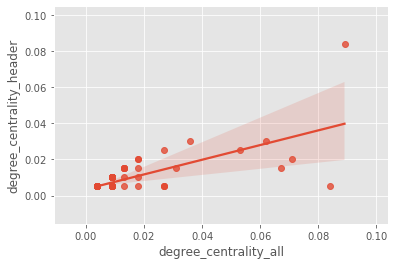

In [48]:
# df_1660.plot.scatter(x='degree_centrality_all', y='degree_centrality_header', ylim=(0,0.04),xlim=(0,0.1))#, 'o', alpha=0.02, markersize=1)
import seaborn as sns
graph_data = df_1660.sort_values('degree_all', ascending=False)[2:]
sns.regplot(data=graph_data, x='degree_centrality_all', y='degree_centrality_header')#, ylim=(0,0.04),xlim=(0,0.1))
# plt.xlabel('Degree centrality in full 1660 Graph')
# plt.ylabel('Degree centrality in header/signature Graph only')
# plt.title('Scatter plot of 1660 degree centrality in full graph vs header/signature only');

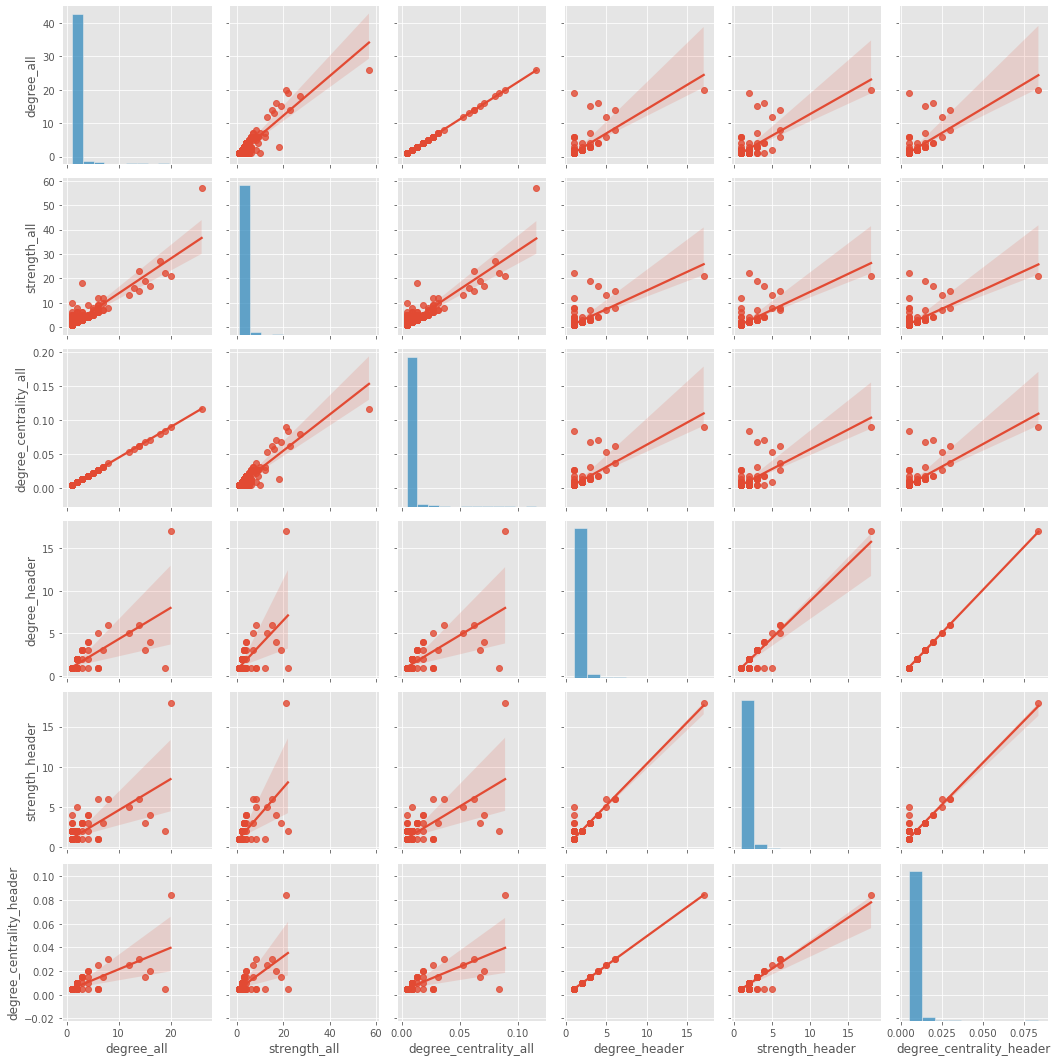

In [50]:
sns.pairplot(graph_data, kind='reg')

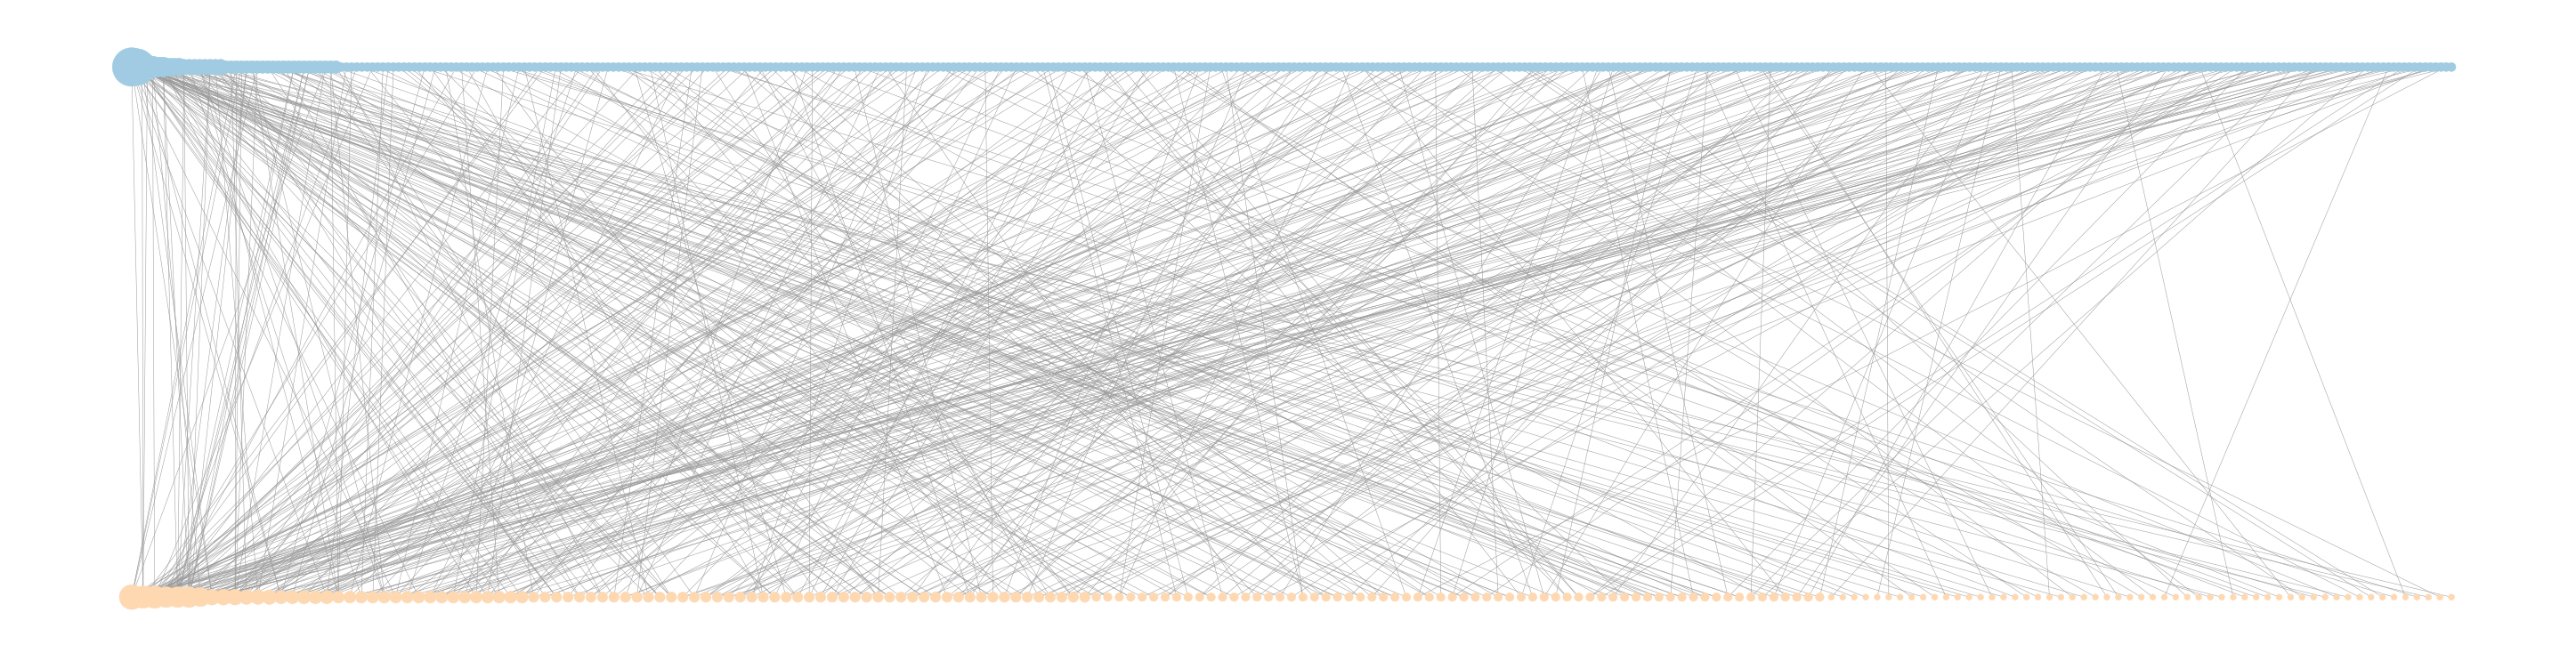

In [63]:
# Visualization of this subgraph

plt.figure(figsize=(40,10))
pos = nx.bipartite_layout(SB_header_signed, hs_names, aspect_ratio=4, align='horizontal')
ordered_pos = {}
degree_names_sorted.reverse()
degree_texts_sorted.reverse()
node_size=[degree_centrality[n]*20000 for n in SB_header_signed.nodes()]
node_color = ["#A0CBE2" if d['bipartite'] == 'person' else "#FED8B1" for n,d in SB_header_signed.nodes(data=True)]
labels = {n:d['displayname'] if d['bipartite'] == 'person' else n for n,d in SB_header_signed.nodes(data=True)}
for i,t in enumerate(pos.items()):
    if i < len(degree_names_sorted):
        ordered_pos[degree_names_sorted[i][0]] = t[1]
    else:
        ordered_pos[degree_texts_sorted[i-len(degree_names_sorted)][0]] = t[1]
nx.draw(SB_header_signed, pos=ordered_pos, node_color=node_color, node_size=node_size, edge_color='#999999',width=.5, with_labels=False, labels=labels)#, horizontalalignment='left')
plt.show()

In [48]:
# Density comparison
aseq = [d for n,d in degree_names]
x = 0
densities = []
while x < 10:
    R = bipartite.preferential_attachment_graph(aseq, len(hs_texts)/len(hs_names))
    top = {n for n,d in R.nodes(data=True) if d['bipartite'] == 0}
    print(nx.info(R))
    density = bipartite.density(R,top)
    print("Density", density)
    densities.append(density)
    x += 1
    
print("Average Density", sum(densities)/len(densities))

Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 701
Number of edges: 553
Average degree:   1.5777
Density 0.004846285974690644
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 671
Number of edges: 553
Average degree:   1.6483
Density 0.005486764297336985
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 715
Number of edges: 553
Average degree:   1.5469
Density 0.004595924337621755
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 708
Number of edges: 553
Average degree:   1.5621
Density 0.004717785967785968
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 684
Number of edges: 553
Average degree:   1.6170
Density 0.005189564564564564
Name: bipartite_preferential_attachment_model
Type: MultiGraph
Number of nodes: 708
Number of edges: 553
Average degree:   1.5621
Density 0.004717785967785968
Name: bipartite_preferential_attachment_model


## Nodes in full graph over time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb5aa3c518>,
      dtype=object)

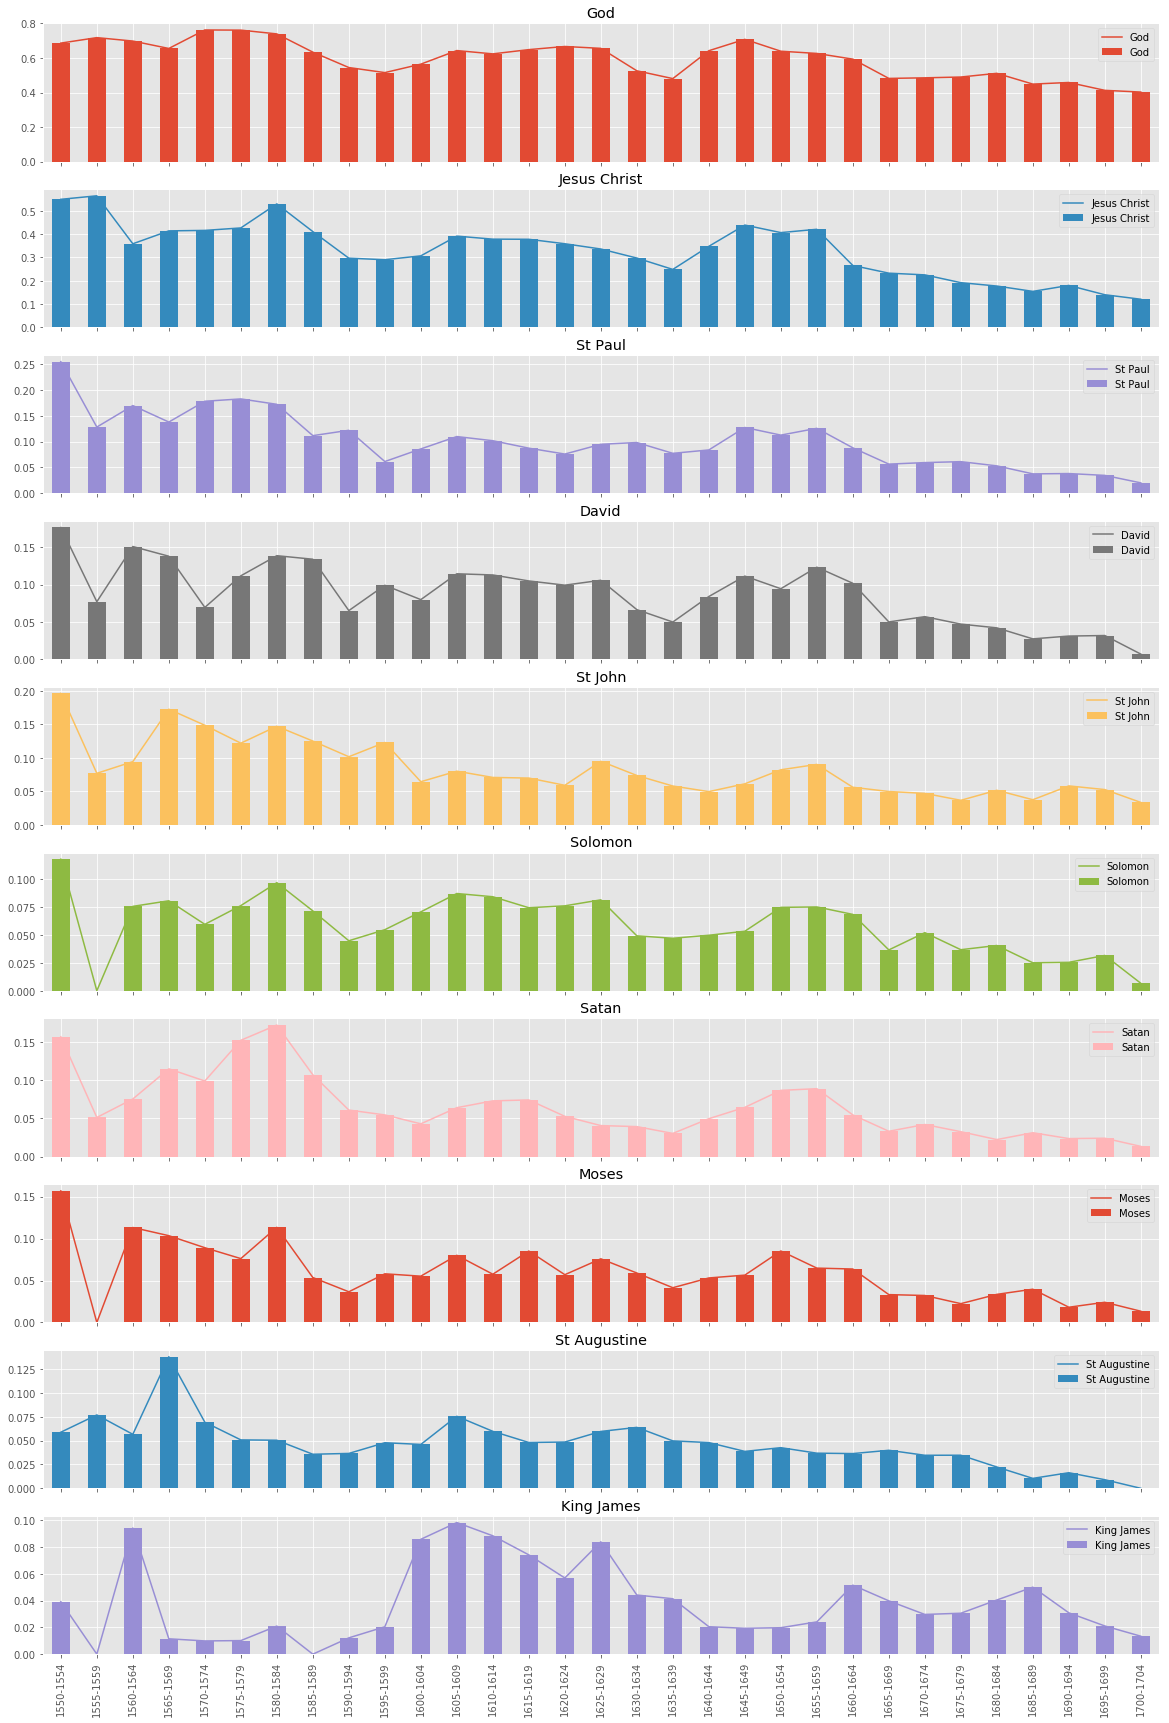

In [6]:
# The maximum range I could analyze was 1550-1700 (data too sparse in earlier years)
# Create a dictionary of subgraphs for that range
graphs_by_year = {f"{x}-{x+4}":filter_by_range(x,x+5,B) for x in range(1550,1701,5)}

all_names = {n for n,d in B.nodes(data=True) if d['bipartite'] == 'person'}
degree_centrality_all = bipartite.degree_centrality(B, all_names)
# To analyze the people with the most connections, I need a sorted list of the highest degree-people.
all_degree_names = sorted(all_names, key=lambda n:degree_centrality_all[n], reverse=True)
top_people = all_degree_names[:10]

# To get the graph for the "projected degree" over time, I needed to
# project every subgraph and record the degreen
dc_by_year = {}

for year,G in graphs_by_year.items():
    sub_people_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 'person'}
#     print(year,G.nodes())
    dc = bipartite.degree_centrality(G,sub_people_nodes)
    dc_by_year[year] = dc
    
# print(dc_by_year)
# Make a dataframe for easy graphing
df = pd.DataFrame(dc_by_year).fillna(0)
df_top = df.filter(top_people, axis=0)
df_top = df_top.rename({n:B.nodes[n]['displayname'] for n in top_people})
# df = hf.create_dataframe(dc_by_year,top_people,B)
tf = df_top.T

# Create subplots for each person
ax = tf.plot.bar(subplots=True, figsize=(20,30), rot=90)
tf.plot(subplots=True, figsize=(20,30),ax=ax, rot=90)

Elizabeth
1550-1554   0.000000
1555-1559   0.051282
1560-1564   0.056604
1565-1569   0.045977
1570-1574   0.059406
1575-1579   0.071066
1580-1584   0.084034
1585-1589   0.071429
1590-1594   0.060976
1595-1599   0.068259
1600-1604   0.058282
1605-1609   0.054920
1610-1614   0.061947
1615-1619   0.034934
1620-1624   0.031646
1625-1629   0.043360
1630-1634   0.044226
1635-1639   0.027624
1640-1644   0.011986
1645-1649   0.025806
1650-1654   0.016743
1655-1659   0.025413
1660-1664   0.034901
1665-1669   0.006645
1670-1674   0.022277
1675-1679   0.024490
1680-1684   0.025140
1685-1689   0.008351
1690-1694   0.012727
1695-1699   0.025602
1700-1704   0.006711

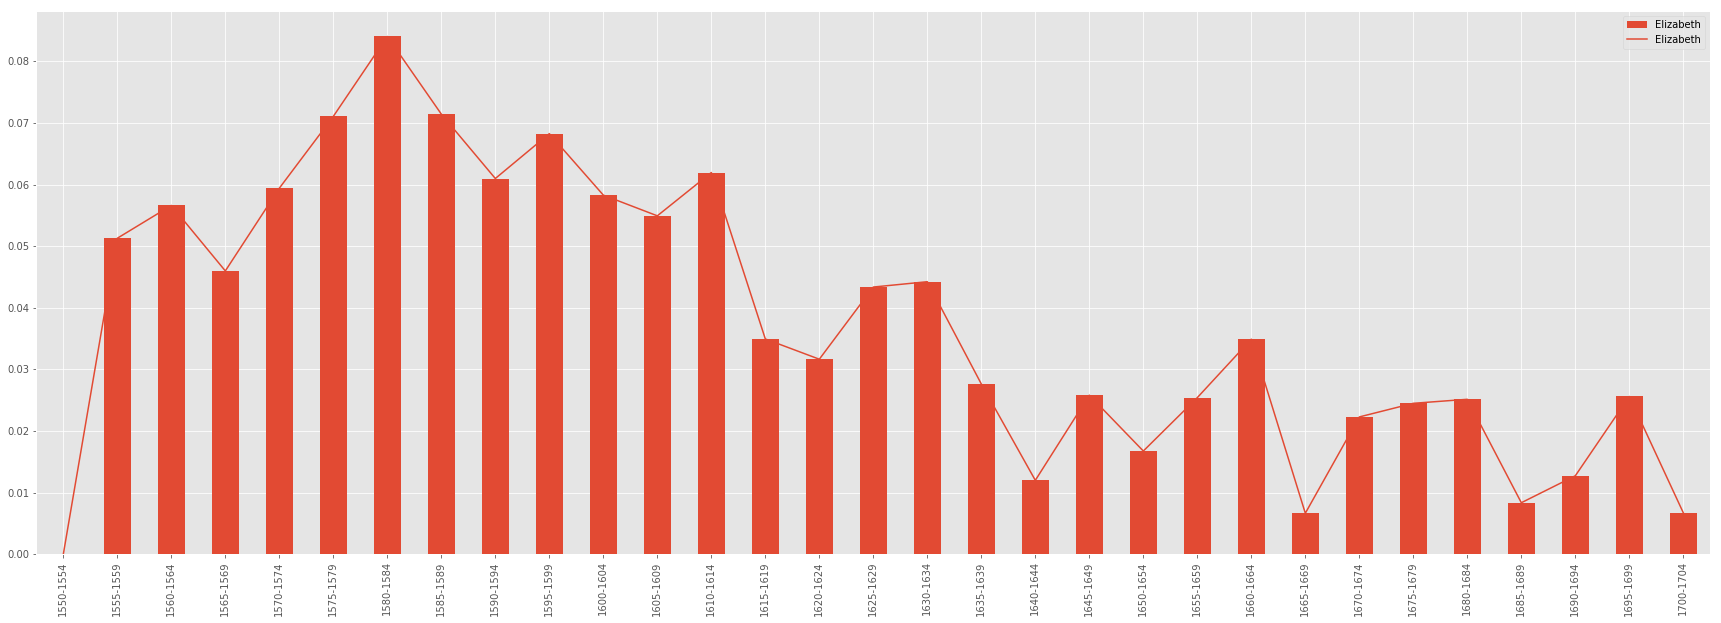

In [7]:
# Time series for Elizabeth

eliz_id = 126796
eliz = df.filter([eliz_id],axis=0).T
eliz = eliz.rename(columns={eliz_id: "Elizabeth"})

ax = eliz.plot.bar(figsize=(30,10), rot=90)
eliz.plot(figsize=(30,10), ax=ax, rot=90)
eliz

# Five-Year Networks Over Time

In [12]:
# Create 5-year Graphs for the 1630s through the 1660s
# Calculate key metrics for those graphs

graphs_by_year = {f"{x}-{x+4}":filter_by_range(x,x+5,B) for x in range(1630,1670,5)}
graph_data = []
for label, G in graphs_by_year.items():
    names = {n for n,d in G.nodes(data=True) if d['bipartite'] == 'person'}
    nodes = len(G.nodes())
    edges = len(G.edges())
    number_of_names = len(names)
    number_of_texts = len({n for n,d in G.nodes(data=True) if d['bipartite'] == 'text'})
    degree_texts, degree_names = bipartite.degrees(G,names)
    average_degree_names = sum([d for name,d in degree_names])/len([d for name,d in degree_names])
    average_degree_texts = sum([d for text,d in degree_texts])/len([d for text,d in degree_texts])
    density = bipartite.density(G,names)
    components = nx.number_connected_components(G)
    average_clustering = bipartite.average_clustering(G)
    aseq = [d for n,d in degree_names]
    bseq = [d for n,d in degree_texts]
    x = 0
    r_densities = []
    r_components = []
    r_clustering = []
    while x < 5:
        R = bipartite.preferential_attachment_graph(aseq, number_of_texts/number_of_names)
        top = {n for n,d in R.nodes(data=True) if d['bipartite'] == 0}
        r_densities.append(bipartite.density(R,top))
        r_clustering.append(bipartite.average_clustering(R))
        x += 1
    density_against_average = density - (sum(r_densities)/len(r_densities))
    clustering_against_average = average_clustering - (sum(r_clustering)/len(r_clustering))
    print(f"{label}|{nodes}|{number_of_names}|{number_of_texts}|{edges}|{round(average_degree_names, 3)}|{round(average_degree_texts, 3)}|{components}|{round(density, 3)}|{round(density_against_average, 3)}|{round(average_clustering, 3)}|{round(clustering_against_average, 3)}")
    graph_data.append({'nodes':nodes, 'number_of_names':number_of_names, 'number_of_texts':number_of_texts, 'edges':edges, 'average_degree_names':average_degree_names, 'average_degree_texts':average_degree_texts, 'components':components, 'density':density, 'density_against_average':density_against_average, 'clustering_against_average':clustering_against_average, 'clustering':average_clustering})

1630-1634|3049|2642|407|3997|1.513|9.821|56|0.004|0.001|0.562|0.011
1635-1639|2546|2184|362|3268|1.496|9.028|58|0.004|0.001|0.567|0.019
1640-1644|3077|2493|584|4408|1.768|7.548|71|0.003|0.001|0.471|0.056
1645-1649|3334|2714|620|5059|1.864|8.16|51|0.003|0.001|0.448|0.058
1650-1654|4200|3543|657|6175|1.743|9.399|66|0.003|0.001|0.486|0.024
1655-1659|4932|4145|787|7726|1.864|9.817|77|0.002|0.001|0.465|0.047
1660-1664|4367|3708|659|6271|1.691|9.516|95|0.003|0.001|0.5|0.036
1665-1669|2237|1936|301|2656|1.372|8.824|69|0.005|0.001|0.621|0.022


In [8]:
graphwide_metrics = pd.DataFrame(graph_data, index=list(graphs_by_year.keys()))
graphwide_metrics

average_degree_names  average_degree_texts  clustering  \
1630-1634              1.512869              9.820639    0.561799   
1635-1639              1.496337              9.027624    0.566900   
1640-1644              1.768151              7.547945    0.470571   
1645-1649              1.864038              8.159677    0.448487   
1650-1654              1.742873              9.398782    0.485938   
1655-1659              1.863932              9.817027    0.465342   
1660-1664              1.691208              9.515933    0.500412   
1665-1669              1.371901              8.823920    0.621496   

           clustering_against_average  components   density  \
1630-1634                    0.017379          56  0.003717   
1635-1639                    0.035421          58  0.004134   
1640-1644                    0.062387          71  0.003028   
1645-1649                    0.061401          51  0.003007   
1650-1654                    0.027896          66  0.002653   
1655-1659                    0.037104          77  0.002368   
1660-1664                    0.036831          95  0.002566   
1665-1669                    0.025667          69  0.004558   

           density_against_average  edges  nodes  number_of_names  \
1630-1634                 0.001191   3997   3049             2642   
1635-1639                 0.001470   3268   2546             2184   
1640-1644                 0.001306   4408   3077             2493   
1645-1649                 0.001391   5059   3334             2714   
1650-1654                 0.001145   6175   4200             3543   
1655-1659                 0.001091   7726   4932             4145   
1660-1664                 0.001061   6271   4367             3708   
1665-1669                 0.001202   2656   2237             1936   

           number_of_texts  
1630-1634              407  
1635-1639              362  
1640-1644              584  
1645-1649              620  
1650-1654              657  
1655-1659              787  
1660-1664              659  
1665-1669              301

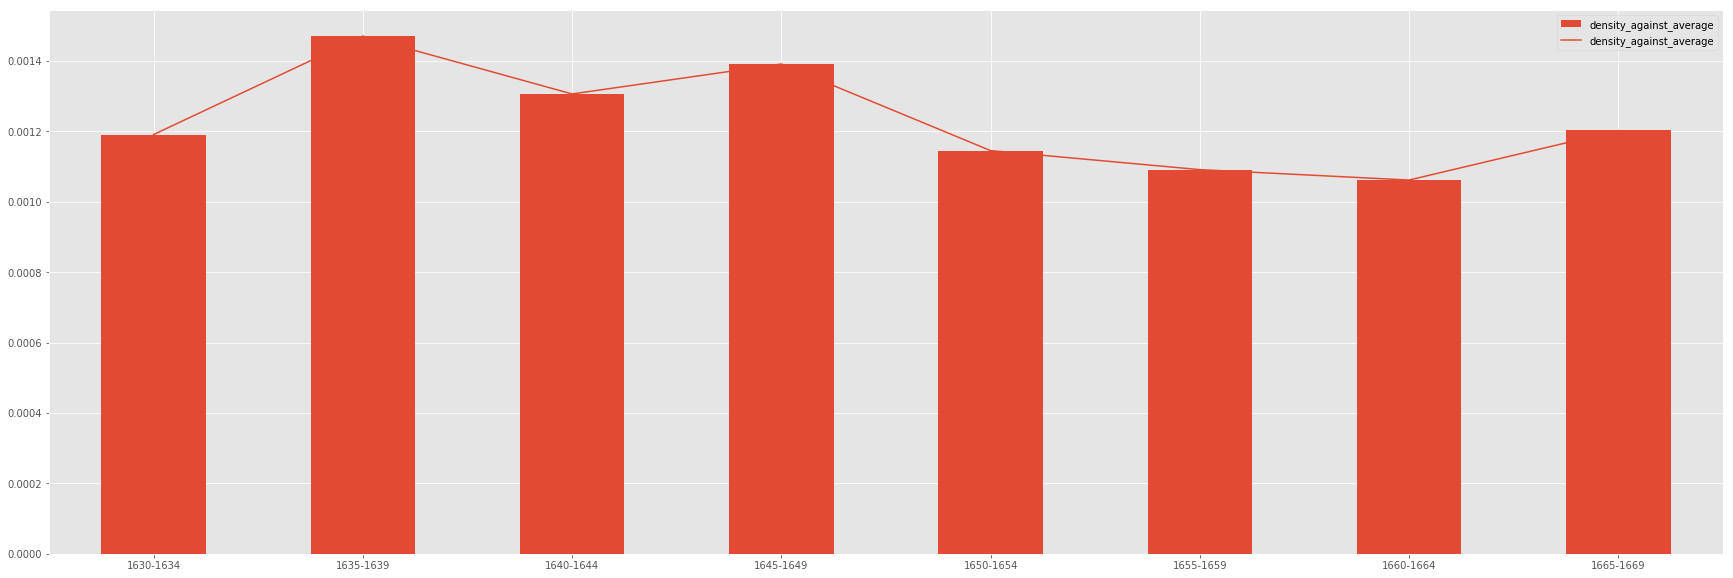

In [9]:
density = graphwide_metrics.filter(['density_against_average'])

ax = density.plot.bar(figsize=(30,10))
density.plot(figsize=(30,10), ax=ax)

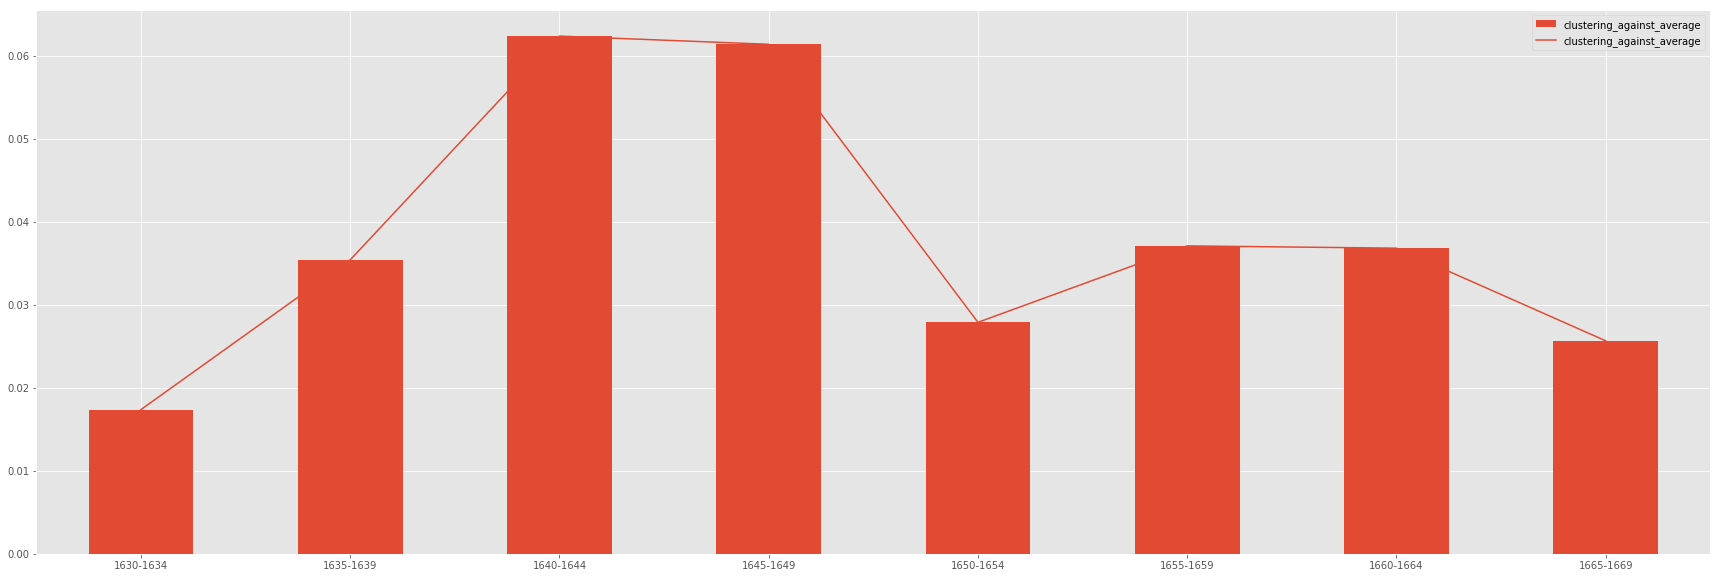

In [10]:
clustering = graphwide_metrics.filter(['clustering_against_average'])

ax = clustering.plot.bar(figsize=(30,10))
clustering.plot(figsize=(30,10), ax=ax)

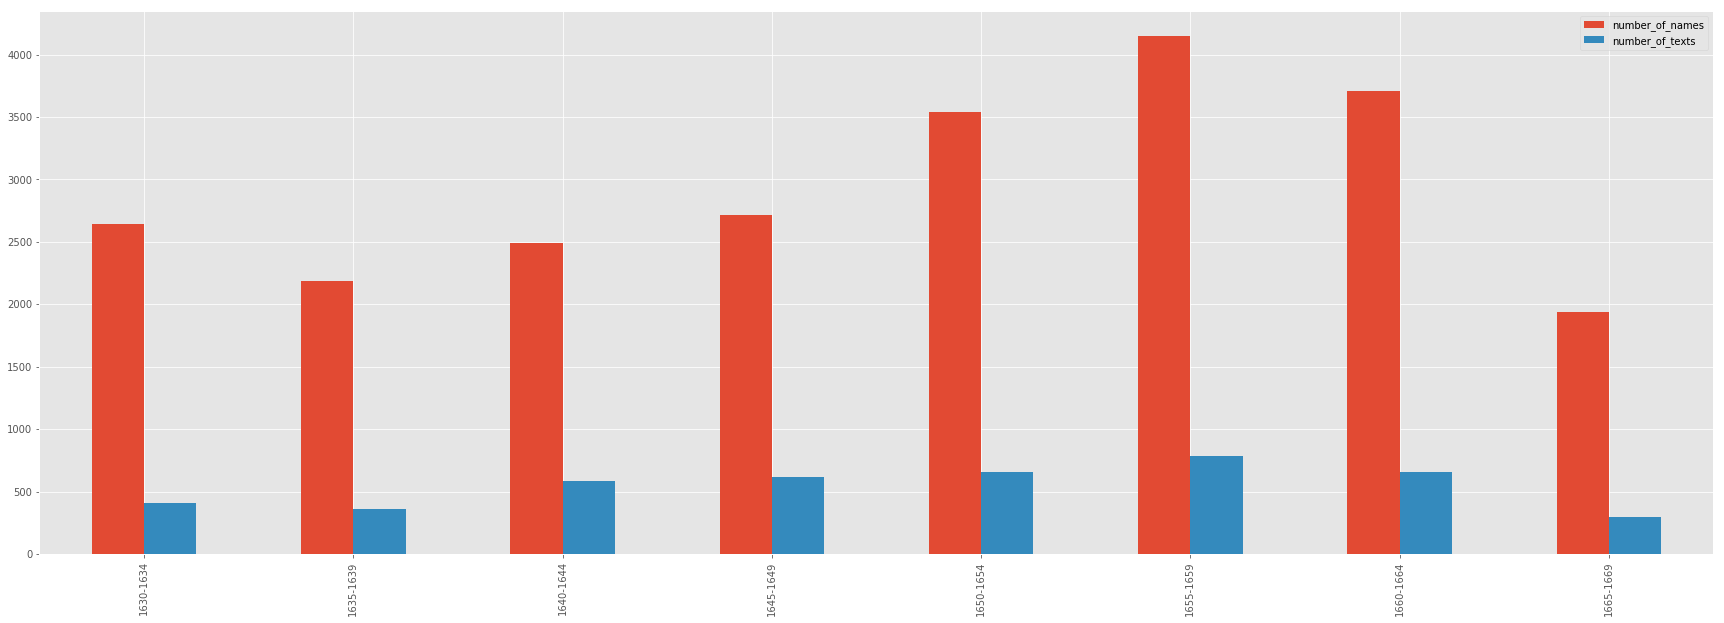

In [11]:
names_texts = graphwide_metrics.filter(['number_of_names','number_of_texts'])

ax = names_texts.plot.bar(figsize=(30,10))

In [4]:
graphs_by_year = {f"{x}-{x+4}":filter_by_range(x,x+5,B) for x in range(1630,1670,5)}

top_names = {}
top_bw = {}
for label,G in graphs_by_year.items():
    names = {n for n,d in G.nodes(data=True) if d['bipartite'] == 'person'}
    degree_texts, degree_names = bipartite.degrees(G,names)
    degree_names = sorted(degree_names, key=lambda d:d[1], reverse=True)
#     betweenness = bipartite.betweenness_centrality(G,names)
#     print(betweenness)
#     betweenness_names = {k:v for k,v in betweenness.items() if G.nodes[k]['bipartite'] == 'person'}
#     betweenness_names = sorted(betweenness_names.items(), key=lambda b:b[1], reverse=True)
    top_names[label] = [f"{G.nodes[nodeid]['displayname']} ({degree})" for nodeid,degree in degree_names[:20]]
#     top_bw[label] = [f"{G.nodes[nodeid]['displayname']} ({bw})" for nodeid,bw in betweenness_names[:20]]
    
top_names_df = pd.DataFrame(top_names)
top_names_df

1630-1634             1635-1639            1640-1644  \
0              God (214)             God (174)            God (375)   
1     Jesus Christ (121)     Jesus Christ (90)   Jesus Christ (203)   
2           St Paul (40)     King Charles (36)         St Paul (49)   
3           St John (30)          St Paul (28)           David (49)   
4      King Charles (27)          St John (21)           Moses (31)   
5             David (27)     St Augustine (18)    King Charles (30)   
6      St Augustine (26)            David (18)           Satan (29)   
7             Moses (24)          Solomon (17)         Solomon (29)   
8           Solomon (20)            Moses (15)         St John (29)   
9   Queen Elizabeth (18)       King James (15)    St Augustine (28)   
10       King James (18)        St Thomas (14)          Joshua (26)   
11            Jacob (17)             Mary (14)        St Peter (23)   
12            Satan (16)           Caesar (13)           Jacob (22)   
13           Apollo (16)        Alexander (13)          Caesar (22)   
14        St Jerome (15)            Satan (11)           Judah (21)   
15             Mary (15)         Maecenas (11)   Martin Luther (20)   
16           Joseph (14)          Abraham (11)       Lord Will (16)   
17        St Thomas (14)         St Peter (11)             Job (14)   
18              Job (13)           Joseph (10)  St Chrysostome (13)   
19       King Henry (12)  Queen Elizabeth (10)            Saul (13)   

              1645-1649           1650-1654           1655-1659  \
0             God (439)           God (420)           God (493)   
1    Jesus Christ (272)  Jesus Christ (267)  Jesus Christ (331)   
2          St Paul (79)        St Paul (74)        St Paul (99)   
3            David (69)          David (62)          David (97)   
4            Satan (40)          Satan (57)        St John (71)   
5          St John (38)          Moses (56)          Satan (70)   
6            Moses (35)        St John (54)        Solomon (59)   
7          Solomon (33)        Solomon (49)          Moses (51)   
8     King Charles (31)       St Peter (29)       St Peter (41)   
9   Thomas Fairfax (28)   St Augustine (28)      Protector (38)   
10        St Peter (28)      Lord Will (26)          Jacob (37)   
11           Jacob (25)            Job (25)            Job (33)   
12    St Augustine (24)          Jacob (23)        Abraham (30)   
13         Abraham (20)        Abraham (22)   St Augustine (29)   
14           Major (20)     King Henry (21)      Lord Will (27)   
15          Isaiah (19)      Aristotle (21)        St Luke (27)   
16          Joshua (19)         Caesar (21)           Adam (26)   
17            Saul (18)         Joshua (19)  Martin Luther (23)   
18          Caesar (17)          Plato (18)      Alexander (23)   
19       Lord Will (17)         Isaiah (16)      St Jerome (22)   

               1660-1664          1665-1669  
0              God (391)          God (145)  
1     Jesus Christ (175)  Jesus Christ (70)  
2             David (67)       St Paul (17)  
3           St Paul (58)       St John (15)  
4        Charles Ii (49)         David (15)  
5           Solomon (45)  St Augustine (12)  
6             Moses (42)    King James (12)  
7           St John (37)       Solomon (11)  
8             Satan (36)         Satan (10)  
9      King Charles (35)        Caesar (10)  
10       King James (34)         Moses (10)  
11           Caesar (27)    Charles Ii (10)  
12     St Augustine (24)         Jacob (10)  
13       King Henry (23)      St Thomas (9)  
14  Queen Elizabeth (23)         Seneca (8)  
15              Job (22)      Alexander (8)  
16         St Peter (21)   King Charles (7)  
17            Aaron (20)      Aristotle (7)  
18        Alexander (19)        St Luke (7)  
19        St Jerome (17)       Plutarch (7)

In [17]:
# The same chart above, but for betweenness centrality
# I ultimately did not use this in the essay.

top_bw_df = pd.DataFrame(top_bw)
top_bw_df

1630-1634  \
0                 God (0.4453942647177455)   
1       Jesus Christ (0.17741728475067647)   
2            St John (0.04662695435660671)   
3            Apollo (0.026323168822141516)   
4           St Paul (0.019105919099003915)   
5      King Charles (0.015594130633398678)   
6   Queen Elizabeth (0.015475410412582796)   
7         St Thomas (0.014688943508722836)   
8       St Augustine (0.01454342014470056)   
9            Robert (0.013650433336344947)   
10            David (0.012801718457998655)   
11        Alexander (0.011816571567046144)   
12         Maecenas (0.011815285157192513)   
13       King Henry (0.010895850961252684)   
14          Solomon (0.010796632082349605)   
15       King James (0.010014461994363356)   
16           George (0.009377949457901063)   
17            Moses (0.008386966987348846)   
18           Cicero (0.007923615866405373)   
19             Mary (0.007368643040722375)   

                                1635-1639  \
0                God (0.4963782381039794)   
1      Jesus Christ (0.12271289919998778)   
2      King Charles (0.04828502179477024)   
3          St Paul (0.024851263561438634)   
4              Mary (0.02100688476760301)   
5       King Henry (0.017951074946444823)   
6          St John (0.017856250064385785)   
7         St Thomas (0.01650707746650585)   
8         Maecenas (0.013393352511257983)   
9            David (0.011910145543834268)   
10          Virgil (0.011877151716059556)   
11      King James (0.011347143900163673)   
12     Aesculapius (0.011310515577813825)   
13        Alexander (0.01090183667930918)   
14           Moses (0.009679520689106384)   
15  Thomas Goodwin (0.009217434747644682)   
16    St Augustine (0.008746362212737118)   
17        Augustus (0.007679785788932121)   
18          Caesar (0.007274735864618833)   
19   James Shirley (0.007099107278048007)   

                                1640-1644  \
0                God (0.5922193775219566)   
1       Jesus Christ (0.1412885024901845)   
2          St Paul (0.022109161364179713)   
3      King Charles (0.01670219938024552)   
4   William Prynne (0.015246354405694613)   
5          St John (0.014046433765237898)   
6            David (0.013669694870983976)   
7              Caesar (0.011047724667931)   
8     St Augustine (0.010914793040446666)   
9         St Peter (0.010661855739681208)   
10       King James (0.01037222184429047)   
11         Solomon (0.007850623674522562)   
12           Bruce (0.007701266005043693)   
13             Mary (0.00706286774201677)   
14        Latimer (0.0065149818007804805)   
15      King Henry (0.006113075586112195)   
16   Edward Dering (0.005933821123521425)   
17          Zoilus (0.005929621214848192)   
18           Satan (0.005264128930637667)   
19           Moses (0.005100653438348073)   

                                 1645-1649  \
0                 God (0.5586405907614832)   
1        Jesus Christ (0.1877843567373764)   
2            St Paul (0.03335081819373371)   
3           St Peter (0.02073066029278022)   
4   Queen Elizabeth (0.020527527250371307)   
5      King Charles (0.016012297813427438)   
6           St John (0.015836680441817533)   
7              David (0.01582450301528829)   
8        King Henry (0.010396498888883107)   
9         St Jerome (0.009997747165299428)   
10   Thomas Fairfax (0.009168917549912376)   
11        Aristotle (0.006972145063785059)   
12           Caesar (0.006507527322655361)   
13          Solomon (0.006437444905996587)   
14         Jeremiah (0.005793128349513783)   
15  Prince Charles (0.0057154240961463125)   
16           Moses (0.0055434418809728785)   
17      Thomas Fuller (0.0051077950614833)   
18        Baltamore (0.005102595604691659)   
19     King William (0.005032909550317749)   

                              1650-1654  \
0              God (0.5356103146322743)   
1    Jesus Christ (0.16624359481053125)   
2        St Paul (0.027630791589408562)   
3         St John (0.02165208308011